In [99]:
fidx = 'resnet'
midx = '15'

import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

mnames, weights = ['resnet_u56'], [1]

# mnames, weights = blend3(mnames18,weights18,mnames19,weights19,mnames2,weights2)

# print(mnames)

threshold = 0.34
nfold = 20

sub_dir = './sub/'

print(fidx,midx,threshold,nfold)

order = np.argsort(-np.array(weights))
for i in range(len(weights)):
    print('%5.3f' % weights[order[i]],mnames[order[i]])

# for m,w in zip(mnames,weights):
#     print('%6.4f' % w,m)

print('sum of weights','%5.3f' % (sum(np.array(weights))))
# assert(len(mnames)==len(weights))

resnet 15 0.34 20
1.000 resnet_u56
sum of weights 1.000


In [100]:
glist = ['iv3_b6','iv3_b9','irv2_b8','nas_b7',
         'gap_c9','resnet_q25','resnet_q26','resnet_q27',
         'resnet_q40','resnet_u25','resnet_u56',
         'se_resnet_b24',
         'se_resnext_e15','se_resnext_e16','se_resnext_e17']
blist = ['blend_0459']
tlist = ['iv3_a4','se_resnext_d10','se_resnext_d11']
klist = ['resnet34_46','resnet50','resnet34']
print(glist)
print(blist)
print(tlist)
print(klist)

gpct = 95.
gscale = 10.

['iv3_b6', 'iv3_b9', 'irv2_b8', 'nas_b7', 'gap_c9', 'resnet_q25', 'resnet_q26', 'resnet_q27', 'resnet_q40', 'resnet_u25', 'resnet_u56', 'se_resnet_b24', 'se_resnext_e15', 'se_resnext_e16', 'se_resnext_e17']
['blend_0459']
['iv3_a4', 'se_resnext_d10', 'se_resnext_d11']
['resnet34_46', 'resnet50', 'resnet34']


In [101]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit, expit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

import scipy.optimize as opt

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

In [102]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
LABEL_MAP = name_label_dict
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [103]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [104]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [105]:
test_df.columns

Index(['Predicted'], dtype='object')

In [106]:
# save a base copy for reuse below
test_df0 = test_df.copy()


In [107]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values

firstm = True
sumw = 0.

for m in mnames:

    firstf = True
    if m in blist: suffix = '.npy'
    elif m in klist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['','a','b','c','d','e','f','g','h','i']:
            if m in blist:
                fname = sub_dir + m + rep + suffix
                if fold > 0: fname = fname + '_' + str(fold)
            else:
                fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in blist:
                    ptestb = np.load(fname)
                    idb = idb0
                elif m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    # ptestb = logit(ptestb)
                elif m in tlist:
                    idb, ptestba, ptestb, ptestbb = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                elif m in glist:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = np.percentile(ptestb, gpct, axis=(2,3))
                    ptestb = 1./(1. + np.exp(-ptestb/gscale))
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                
                # ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                navg = 1
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                navg += 1
    
    if navg == 0: print('Error: No files found')
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)



./sub/resnet_u56_0_mm.pkl
0.11920292202211755 0.38460032029898034 0.8020597807305822
(11702, 28) 0.11920292202211755 0.38460032029898034 0.8020597807305822

./sub/resnet_u56_1_mm.pkl
0.16389476312456452 0.3974300004659906 0.7768946270119832
(11702, 28) 0.16389476312456452 0.3974300004659906 0.7768946270119832
[[1.    0.911]
 [0.911 1.   ]]

./sub/resnet_u56_2_mm.pkl
0.1617102059575853 0.39935257941598035 0.7681224270591098
(11702, 28) 0.1617102059575853 0.39935257941598035 0.7681224270591098
[[1.    0.935]
 [0.935 1.   ]]

./sub/resnet_u56_3_mm.pkl
0.1733745002129598 0.4057714636037796 0.7778604497139071
(11702, 28) 0.1733745002129598 0.4057714636037796 0.7778604497139071
[[1.    0.928]
 [0.928 1.   ]]
resnet_u56 4 (11702, 28) 0.1861690531223258 0.39678859094618274 0.769444670307996 0.7572362477720537


In [108]:
test_df.columns

Index(['Predicted', 'resnet_u56'], dtype='object')

In [109]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [110]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])).flatten())
print(clist)
r = np.corrcoef(f)
print(r)

['resnet_u56']
1.0


In [111]:
# d = pd.DataFrame(r, columns=mnames)
# d['id'] = mnames
# d.set_index('id',inplace=True)
# del d.index.name

# sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [112]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = clist
fdf.to_csv(fname)
print(fname)

(327656, 1)
flat.csv


In [113]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    f.append(np.array(list(test_df[c])))
m = np.array(f)
print(m.shape)

(1, 11702, 28)


In [114]:
weights = np.array(weights)
print(weights)

[1]


In [115]:
ens = np.average(m,axis=0,weights=weights)
print(ens.shape)

(11702, 28)


In [116]:
print(ens[1])

[0.504 0.374 0.427 0.438 0.438 0.601 0.456 0.427 0.305 0.298 0.318 0.427 0.418 0.392 0.429 0.352
 0.446 0.401 0.463 0.451 0.346 0.468 0.418 0.443 0.437 0.54  0.454 0.36 ]


In [117]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [118]:
# desired class proportions from lb probing

desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : 0.0018,
9 : 0.0014,
10 : 0.0009,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : 0.0007,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : 0.0056,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : 0.0104,
25 : 0.222493888,
26 : 0.028806584,
27 : 0.0004
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.0018, 9: 0.0014, 10: 0.0009, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.0007, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.0056, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.0104, 25: 0.222493888, 26: 0.028806584, 27: 0.0004}


In [119]:
# fixed global threshold
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold 0.34
0 0.3624 0.9994 Nucleoplasm
1 0.0438 0.9163 Nuclear membrane
2 0.0753 0.9930 Nucleoli
3 0.0593 0.9671 Nucleoli fibrillar center
4 0.0753 0.9456 Nuclear speckles
5 0.0753 0.9951 Nuclear bodies
6 0.0438 0.9346 Endoplasmic reticulum
7 0.0753 0.9915 Golgi apparatus
8 0.0018 0.0660 Peroxisomes
9 0.0014 0.0728 Endosomes
10 0.0009 0.1304 Lysosomes
11 0.0438 0.9615 Intermediate filaments
12 0.0438 0.8785 Actin filaments
13 0.0142 0.8280 Focal adhesion sites
14 0.0438 0.8386 Microtubules
15 0.0007 0.1216 Microtubule ends
16 0.0288 0.9686 Cytokinetic bridge
17 0.0142 0.7867 Mitotic spindle
18 0.0288 0.9602 Microtubule organizing center
19 0.0593 0.9909 Centrosome
20 0.0056 0.4482 Lipid droplets
21 0.1261 0.9944 Plasma membrane
22 0.0288 0.9360 Cell junctions
23 0.0753 0.9849 Mitochondria
24 0.0104 0.4607 Aggresome
25 0.2225 0.9998 Cytosol
26 0.0288 0.7277 Cytoplasmic bodies
27 0.0004 0.3048 Rods & rings


In [120]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

from scipy.special import expit

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

pred_t = expit(ens)
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
np.set_printoptions(precision=3, suppress=True, linewidth=100)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))
pred = (pred_t > th_t).astype(int)

Thresholds:  [1.575 2.322 2.759 2.514 2.399 2.762 2.483 2.709 1.326 1.289 1.371 2.591 2.281 2.179 2.176 1.341
 2.672 2.147 2.61  2.768 1.69  2.669 2.461 2.661 1.679 2.018 1.968 1.565]
Fractions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Fractions (th = 0.5):  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [121]:
# custom thresholds to match lb proportions
thresholds = np.linspace(0.9, 0.1, 100001)
pred = ens.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

0 0.5697 0.3624 0.3624 Nucleoplasm
1 0.5238 0.0438 0.0439 Nuclear membrane
2 0.5555 0.0753 0.0753 Nucleoli
3 0.4957 0.0593 0.0594 Nucleoli fibrillar center
4 0.4841 0.0753 0.0753 Nuclear speckles
5 0.5104 0.0753 0.0753 Nuclear bodies
6 0.5171 0.0438 0.0439 Endoplasmic reticulum
7 0.5179 0.0753 0.0753 Golgi apparatus
8 0.4135 0.0018 0.0019 Peroxisomes
9 0.4731 0.0014 0.0015 Endosomes
10 0.4998 0.0009 0.0009 Lysosomes
11 0.5316 0.0438 0.0440 Intermediate filaments
12 0.4937 0.0438 0.0439 Actin filaments
13 0.5460 0.0142 0.0143 Focal adhesion sites
14 0.5563 0.0438 0.0439 Microtubules
15 0.5104 0.0007 0.0008 Microtubule ends
16 0.5299 0.0288 0.0289 Cytokinetic bridge
17 0.5537 0.0142 0.0143 Mitotic spindle
18 0.5434 0.0288 0.0289 Microtubule organizing center
19 0.5153 0.0593 0.0594 Centrosome
20 0.5070 0.0056 0.0056 Lipid droplets
21 0.5387 0.1261 0.1261 Plasma membrane
22 0.5263 0.0288 0.0289 Cell junctions
23 0.5356 0.0753 0.0753 Mitochondria
24 0.5242 0.0104 0.0104 Aggresome
25 0.5574

In [122]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [123]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.591608272090241 5.0


In [124]:
print(sum(xps==0)/pred.shape[0])

0.060246111775764825


In [125]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 26
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3 4
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 21 25
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 0 21 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 19 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2', '5', '0 5 25', '0 16', '5', '

In [126]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/resnet15.csv


In [127]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 4241 prop 0.3624
1 Nuclear membrane count 514 prop 0.0439
2 Nucleoli count 881 prop 0.0753
3 Nucleoli fibrillar center count 695 prop 0.0594
4 Nuclear speckles count 881 prop 0.0753
5 Nuclear bodies count 881 prop 0.0753
6 Endoplasmic reticulum count 514 prop 0.0439
7 Golgi apparatus count 881 prop 0.0753
8 Peroxisomes count 22 prop 0.0019
9 Endosomes count 17 prop 0.0015
10 Lysosomes count 11 prop 0.0009
11 Intermediate filaments count 515 prop 0.0440
12 Actin filaments count 514 prop 0.0439
13 Focal adhesion sites count 167 prop 0.0143
14 Microtubules count 514 prop 0.0439
15 Microtubule ends count 9 prop 0.0008
16 Cytokinetic bridge count 338 prop 0.0289
17 Mitotic spindle count 167 prop 0.0143
18 Microtubule organizing center count 338 prop 0.0289
19 Centrosome count 695 prop 0.0594
20 Lipid droplets count 66 prop 0.0056
21 Plasma membrane count 1476 prop 0.1261
22 Cell junctions count 338 prop 0.0289
23 Mitochondria count 881 prop 0.0753
24 Aggresome count 122 

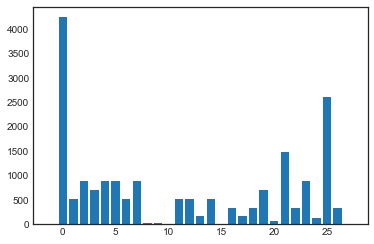

In [128]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [129]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


# computute confusion matrices between two submission files
def f1_confusion(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
    
    y0avg = np.average(y0,axis=0)
    y1avg = np.average(y1,axis=0)
    cm = [confusion_matrix(y0[:,i], y1[:,i]) for i in range(y0.shape[1])]
    fm = [f1_score(y0[:,i], y1[:,i]) for i in range(y0.shape[1])]
    for i in range(y0.shape[1]):
        print(LABEL_MAP[i])
        print(cm[i],' %4.2f' % fm[i],' %6.4f' % y0avg[i],' %6.4f' % y1avg[i],
             ' %6.4f' % (y0avg[i] - y1avg[i]))
        print()
#     print('y0avg')
#     print(y0avg)
#     print('y1avg')
#     print(y1avg)
#     print('y0avg - y1avg')
#     print(y0avg-y1avg)
    print('f1 macro')
    print(np.mean(fm))       
    return f1_score(y0, y1, average='macro')
    
# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [130]:
f1_sub(fname,'sub/protein_classification.csv')

0.5704461954111765

In [131]:
f1_sub(fname,'sub/submit_InceptionV3.csv')

0.5252787651470265

In [132]:
f1_sub(fname,'sub/submit_InceptionResNetV2_3.csv')

0.5146418521659651

In [133]:
f1_sub(fname,'sub/blend_InceptionV3_InceptionResNetV2_DenseNet201_2.csv')

0.5763374618657818

In [134]:
f1_sub(fname,'sub/iv3_0.csv')

0.5551263669018865

In [135]:
f1_sub(fname,'sub/irv2_0.csv')

0.5670087952788291

In [136]:
f1_sub(fname,'sub/resnet34_0.csv')

0.588882011800494

In [137]:
f1_sub(fname,'sub/resnet50_0.csv')

0.600126852278974

In [138]:
f1_sub(fname,'sub/resnet4.csv')

0.6077963269754957

In [139]:
f1_sub(fname,'sub/resnet5.csv')

0.5755501505776314

In [140]:
f1_sub(fname,'sub/resnet6.csv')

0.6128827855952822

In [141]:
f1_sub(fname,'sub/resnet7.csv')

0.591133030721101

In [142]:
f1_sub(fname,'sub/resnet8.csv')

0.57915087707874

In [143]:
f1_sub(fname,'sub/resnet9.csv')

0.5908731629014038

In [144]:
f1_sub(fname,'sub/resnet10.csv')

0.5828156984653329

In [145]:
f1_sub(fname,'sub/se_resnet1.csv')

0.6048417125145226

In [146]:
f1_sub(fname,'sub/se_resnet2.csv')

0.6149055280602435

In [147]:
f1_sub(fname,'sub/se_resnext6.csv')

0.5610912432149445

In [148]:
f1_sub(fname,'sub/se_resnext9.csv')

0.5745264052102609

In [149]:
f1_sub(fname,'sub/ens0.csv')

0.5901227462212271

In [150]:
f1_sub(fname,'sub/ens1.csv')

0.6019118596844449

In [151]:
f1_sub(fname,'sub/ens2.csv')

0.5989822299874799

In [152]:
f1_sub(fname,'sub/ens6.csv')

0.6363227336848817

In [153]:
f1_sub(fname,'sub/ens7.csv')

0.61357889748231

In [154]:
f1_sub(fname,'sub/ens8.csv')

0.6736189281357039

In [155]:
f1_sub(fname,'sub/ens9.csv')

0.6789519333509214

In [156]:
f1_sub(fname,'sub/ens10.csv')

0.6944458953726086

In [157]:
f1_sub(fname,'sub/ens11.csv')

0.6932826389228689

In [158]:
f1_sub(fname,'sub/ens12.csv')

0.6988003501330667

In [159]:
f1_sub(fname,'sub/ens13.csv')

0.5902712130696945

In [160]:
f1_sub(fname,'sub/ens14.csv')

0.6804762685222985

In [161]:
f1_sub(fname,'sub/ens15.csv')

0.6784151271941247

In [162]:
f1_sub(fname,'sub/ens16.csv')

0.7015706210345158

In [163]:
f1_sub(fname,'sub/ens17.csv')

0.6867927647959277

In [164]:
f1_sub(fname,'sub/ens18.csv')

0.697140167824175

In [165]:
f1_sub(fname,'sub/ens19.csv')

0.6984219256985272

In [166]:
f1_sub(fname,'sub/ens20.csv')

0.6618149967978179

In [167]:
f1_sub(fname,'sub/ens21.csv')

0.6611316384362995

In [168]:
f1_sub(fname,'sub/ens22.csv')

0.7155669959874956

In [169]:
f1_sub(fname,'sub/ens23.csv')

0.7199183473761386

In [170]:
f1_sub(fname,'sub/ens24.csv')

0.7074110181915815

In [171]:
f1_sub(fname,'sub/ens25.csv')

0.7070672268971615

In [172]:
f1_sub(fname,'sub/ens26.csv')

0.7092357079987358

In [173]:
f1_sub(fname,'sub/ens27.csv')

0.7014998801860186

In [174]:
f1_sub(fname,'sub/ens28.csv')

0.7199705462255989

In [175]:
f1_sub(fname,'sub/ens31.csv')

0.7139277389214705

In [176]:
f1_sub(fname,'sub/ens32.csv')

0.7025134143823004

In [177]:
f1_sub(fname,'sub/ens33.csv')

0.7197370538949677

In [178]:
f1_sub(fname,'sub/ens34.csv')

0.711419260682176

In [179]:
f1_sub(fname,'sub/ens35.csv')

0.7038904104376567

In [180]:
f1_sub(fname,'sub/ens36.csv')

0.7139337992359197

In [181]:
f1_sub(fname,'sub/ens43.csv')

0.732955149998485

In [182]:
f1_sub(fname,'sub/ens44.csv')

0.729563172676362

In [183]:
f1_sub(fname,'sub/ens45.csv')

0.7364306153378547

In [184]:
f1_sub(fname,'sub/ens46.csv')

0.717362685215381

In [185]:
f1_sub(fname,'sub/ens47.csv')

0.732467736353354

In [186]:
f1_sub(fname,'sub/ens48.csv')

0.7345614037992132

In [187]:
f1_sub(fname,'sub/ens49.csv')

0.7332728148879376

In [188]:
f1_sub(fname,'sub/ens51.csv')

0.7386251234021534

In [189]:
f1_sub(fname,'sub/resnet11.csv')

0.6734561683436223

In [190]:
f1_sub(fname,'sub/resnet12.csv')

0.6992858455005224

In [191]:
f1_sub(fname,'sub/resnet13.csv')

0.7088122312524543

In [192]:
f1_sub(fname,'sub/resnet14.csv')

0.6829683185980825

In [193]:
print(fname)

sub/resnet15.csv


In [194]:
# f1_confusion(fname, 'sub/ens19.csv')

In [195]:
# f1_confusion(fname, 'sub/ens21.csv')

In [196]:
# f1_confusion(fname, 'sub/ens22.csv')